In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import seaborn as sns

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")

# Loading UK inflation rates

In [2]:
# Loading CSV file
file_path = 'Inflation_data.csv'
df = pd.read_csv(file_path, header=None)

# Drop empty rows
df.dropna(how='all', inplace=True)

# Rename columns manually
df.columns = ['Year', 'Inflation_Rate']

# Skip metadata rows (first few rows with titles)
inflation_data = df.iloc[7:].reset_index(drop=True)

# Clean inflation rate
inflation_data['Inflation_Rate'] = pd.to_numeric(inflation_data['Inflation_Rate'], errors='coerce')

# Convert Year to datetime
try:
    # Try converting as quarterly (e.g., "2022 Q1")
    inflation_data['Date'] = pd.PeriodIndex(inflation_data['Year'].str.replace(' ', ''), freq='Q').to_timestamp()
except:
    # Fallback to monthly (e.g., "2022 JAN")
    inflation_data['Date'] = pd.to_datetime(inflation_data['Year'], format='%Y %b', errors='coerce')

# Forward fill inflation rate
inflation_data['Inflation_Rate'] = inflation_data['Inflation_Rate'].ffill()

# Sort by Date
inflation_data = inflation_data.sort_values(by='Date').reset_index(drop=True)

# Save cleaned data
inflation_data.to_csv('UK_Inflation_Cleaned.csv', index=False)

# Show final output
print("\n Cleaned Inflation Data:")
inflation_data[['Date', 'Inflation_Rate']].head(10)


 Cleaned Inflation Data:


,Date,Inflation_Rate
0,1989-01-01,5.7
1,1989-02-01,5.8
2,1989-03-01,5.9
3,1989-04-01,5.6
4,1989-05-01,5.9
5,1989-06-01,5.8
6,1989-07-01,5.7
7,1989-08-01,5.5
8,1989-09-01,5.7
9,1989-10-01,5.8


# Loading cryptocurrency data

In [3]:
# Load the CSV file
btc_data = pd.read_csv('BTC_GBP_Historical_Data.csv', low_memory=False)

# Check for missing values
print("\nMissing values before cleaning:")
print(btc_data.isnull().sum())

# Drop rows with invalid dates
btc_data = btc_data.dropna(subset=['Date']).reset_index(drop=True)

# Recheck missing values
print("\nMissing values after dropping invalid dates:")
print(btc_data.isnull().sum())


# Define numeric columns
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Clean numeric columns
for col in numeric_cols:
    btc_data[col] = (
        btc_data[col].astype(str)
                     .str.replace(',', '', regex=True)
                     .replace('', 'NaN')
                     .astype(float)
    )

# Recheck missing values after cleaning
print("\nMissing values after cleaning numeric columns:")
print(btc_data.isnull().sum())

# Ensure all numeric columns are floats
btc_data[numeric_cols] = btc_data[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Save cleaned data
btc_data.to_csv('BTC_GBP_Cleaned.csv', index=False)

# Display cleaned data
btc_data.head()


Missing values before cleaning:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Missing values after dropping invalid dates:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Missing values after cleaning numeric columns:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


,Date,Open,High,Low,Close,Adj Close,Volume
0,"Jul 14, 2025",88266.31,91071.47,88110.45,89481.22,89481.22,1.324902e+11
1,"Jul 13, 2025",87086.71,87583.21,86662.43,87001.89,87001.89,3.372687e+10
2,"Jul 12, 2025",85407.86,87735.09,85031.73,87076.55,87076.55,6.441129e+10
3,"Jul 11, 2025",81871.49,85883.07,81640.85,85408.57,85408.57,7.062566e+10
4,"Jul 10, 2025",80198.41,82326.71,79832.30,81869.55,81869.55,4.259982e+10


# Merging two datasets

In [4]:
import pandas as pd

# 1. Load BTC-GBP data
btc_cleaned = pd.read_csv('BTC_GBP_Cleaned.csv')
btc_cleaned['Date'] = pd.to_datetime(btc_cleaned['Date'])
btc_cleaned = btc_cleaned.sort_values(by='Date').reset_index(drop=True)

# 2. Load inflation data
inflation_cleaned = pd.read_csv('UK_Inflation_Cleaned.csv')
inflation_cleaned['Date'] = pd.to_datetime(inflation_cleaned['Date'], errors='coerce')
inflation_cleaned = inflation_cleaned.dropna(subset=['Date']).sort_values(by='Date').reset_index(drop=True)

# 3. Merge using asof
merged_df = pd.merge_asof(btc_cleaned, inflation_cleaned[['Date', 'Inflation_Rate']], on='Date')

# 4. Forward fill inflation rate (to cover all days in a quarter/month)
merged_df['Inflation_Rate'] = merged_df['Inflation_Rate'].ffill()


# 6. Save final dataset
merged_df.to_csv('BTC_GBP_with_UK_Inflation.csv', index=False)
print("\n Merged dataset saved as 'BTC_GBP_with_UK_Inflation.csv'")

# 5. Show sample
print(" Final Merged Dataset Sample:")
merged_df[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Inflation_Rate']].head(10)


 Merged dataset saved as 'BTC_GBP_with_UK_Inflation.csv'
 Final Merged Dataset Sample:


,Date,Open,High,Low,Close,Adj Close,Volume,Inflation_Rate
0,2024-07-14,44617.23,46069.53,44530.71,45641.77,45641.77,1.316121e+10,3.1
1,2024-07-15,45636.61,47249.25,45636.61,46877.18,46877.18,1.713783e+10,3.1
2,2024-07-16,46898.51,50018.26,46827.30,50018.26,50018.26,2.937286e+10,3.1
3,2024-07-17,49952.16,50371.01,48179.85,50160.61,50160.61,3.206825e+10,3.1
4,2024-07-18,50156.51,50939.89,49132.26,49290.87,49290.87,2.500342e+10,3.1
5,2024-07-19,49280.07,50168.35,48874.61,49404.61,49404.61,2.103583e+10,3.1
6,2024-07-20,49403.27,52233.65,48935.09,51659.68,51659.68,2.865542e+10,3.1
7,2024-07-21,51659.50,52342.47,51327.44,51996.35,51996.35,1.473221e+10,3.1
8,2024-07-22,51997.33,52927.40,50971.42,52699.80,52699.80,2.060854e+10,3.1
9,2024-07-23,52698.61,52979.33,51586.99,52263.20,52263.20,3.298026e+10,3.1


# Exploratory data analysis

In [18]:
# Load merged dataset
merged_data = pd.read_csv('BTC_GBP_with_UK_Inflation.csv')

# Ensure 'Date' is in datetime format
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

# Set Date as index
merged_data.set_index('Date', inplace=True)

# Basic information and summary stats
print(" Dataset Info:")
print(merged_data.info())

print("\n Summary Statistics:")
print(merged_data.describe())

# Check date range
print("\n Date range of BTC prices:")
print(f"Start: {merged_data.index.min()}")
print(f"End: {merged_data.index.max()}")

# Check for missing values
print("\n❌ Missing Values:")
print(merged_data.isnull().sum())

 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2024-07-14 to 2025-07-14
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Open            366 non-null    float64
 1   High            366 non-null    float64
 2   Low             366 non-null    float64
 3   Close           366 non-null    float64
 4   Adj Close       366 non-null    float64
 5   Volume          366 non-null    float64
 6   Inflation_Rate  366 non-null    float64
dtypes: float64(7)
memory usage: 22.9 KB
None

 Summary Statistics:
               Open          High           Low         Close     Adj Close  \
count    366.000000    366.000000    366.000000    366.000000    366.000000   
mean   66123.745656  67355.064754  64936.663525  66242.417596  66242.417596   
std    13594.292640  13753.216077  13406.262394  13596.497507  13596.497507   
min    41082.180000  41752.830000  38611.300000  41081.920000  41081.9200

# Visualizing Trends

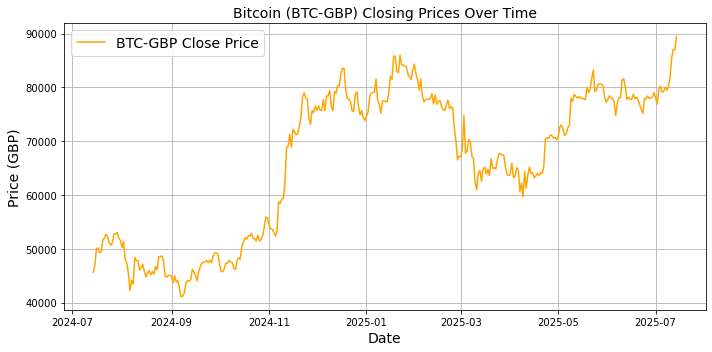

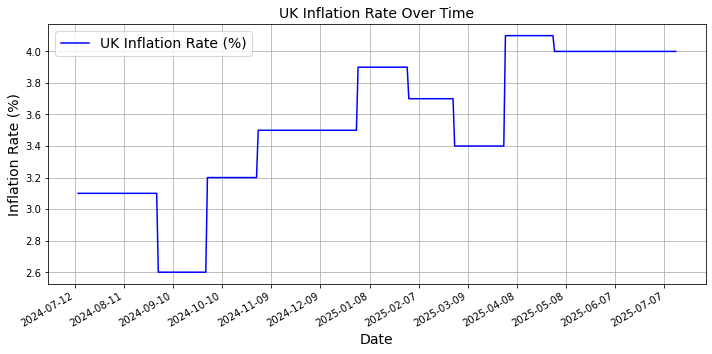

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load merged dataset
merged_data = pd.read_csv('BTC_GBP_with_UK_Inflation.csv')

# Ensure 'Date' is set as the index
merged_data['Date'] = pd.to_datetime(merged_data['Date'])
merged_data.set_index('Date', inplace=True)

# Ensure Inflation_Rate is numeric
merged_data['Inflation_Rate'] = pd.to_numeric(merged_data['Inflation_Rate'], errors='coerce')

# Handle missing values
merged_data['Inflation_Rate'].fillna(method='ffill', inplace=True)
merged_data.dropna(subset=['Close'], inplace=True)

# Plot BTC Price Trends
plt.figure(figsize=(10, 5))
plt.plot(merged_data.index, merged_data['Close'], label='BTC-GBP Close Price', color='orange')
plt.title('Bitcoin (BTC-GBP) Closing Prices Over Time', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (GBP)', fontsize=14)
plt.grid(True)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

# Plot UK Inflation Rate Over Time
plt.figure(figsize=(10, 5))
plt.plot(merged_data.index, merged_data['Inflation_Rate'], label='UK Inflation Rate (%)', color='blue')
plt.title('UK Inflation Rate Over Time', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Inflation Rate (%)', fontsize=14)
plt.grid(True)
plt.legend(fontsize=14)
plt.tight_layout()

# Format x-axis as dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))  # Show one date every 30 days
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels better
plt.show()


📊 Correlation Matrix:
                   Close  Inflation_Rate
Close           1.000000        0.801878
Inflation_Rate  0.801878        1.000000


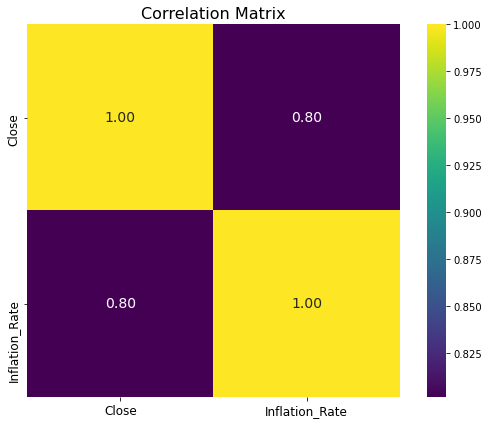

In [7]:
# Correlation Between BTC Price and Inflation Rate
numeric_cols = ['Close', 'Inflation_Rate']
correlation_matrix = merged_data[numeric_cols].corr()
print("\n Correlation Matrix:")
print(correlation_matrix)

# Plotting correlation matrix p
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='viridis',  
    annot_kws={"fontsize": 14},  
    square=True, 
    cbar=True,  
    fmt=".2f"     
)
plt.title('Correlation Matrix', fontsize=16) 
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.tight_layout()  
plt.show()

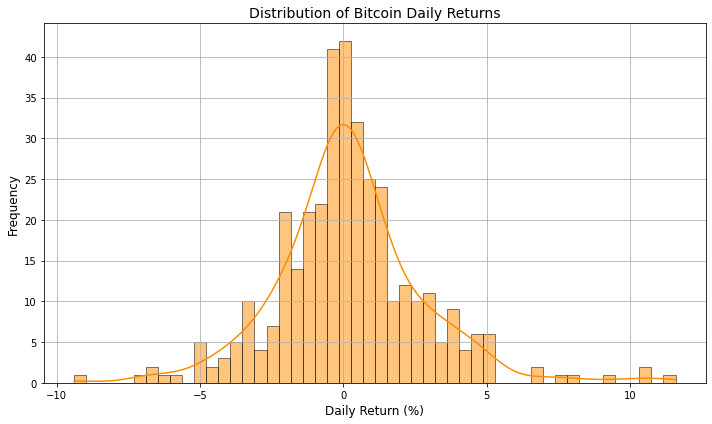

In [8]:
# Calculate Daily Returns
merged_data['Daily_Returns'] = merged_data['Close'].pct_change() * 100

# Plot Daily Returns
plt.figure(figsize=(10, 6))  
sns.histplot(
    merged_data['Daily_Returns'].dropna(),
    bins=50,
    kde=True,
    color='darkorange',  
    edgecolor='black',   
    linewidth=0.5      
)
plt.title('Distribution of Bitcoin Daily Returns', fontsize=14)  
plt.xlabel('Daily Return (%)', fontsize=12) 
plt.ylabel('Frequency', fontsize=12)  
plt.grid(True)
plt.tight_layout() 
plt.show()

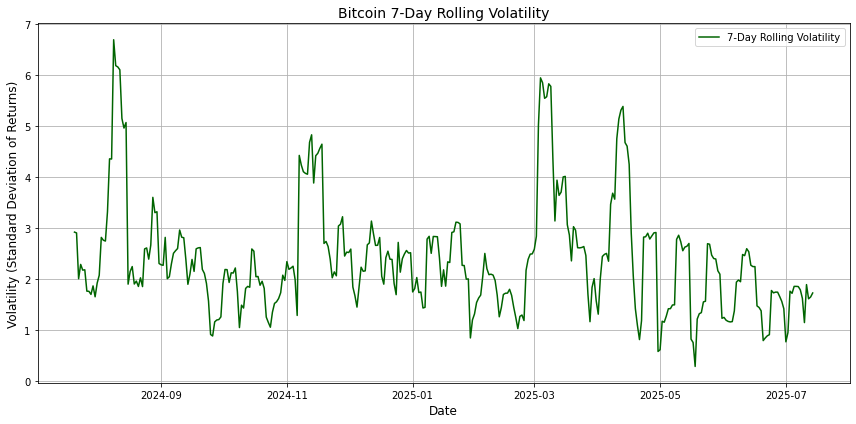

In [9]:
# Calculate Rolling Volatility
merged_data['Rolling_Volatility'] = merged_data['Daily_Returns'].rolling(window=7).std()

# Plot Rolling Volatility
plt.figure(figsize=(12, 6))  
plt.plot(
    merged_data.index,
    merged_data['Rolling_Volatility'],
    label='7-Day Rolling Volatility',
    color='darkgreen'
)
plt.title('Bitcoin 7-Day Rolling Volatility', fontsize=14)  
plt.xlabel('Date', fontsize=12) 
plt.ylabel('Volatility (Standard Deviation of Returns)', fontsize=12)  
plt.grid(True)
plt.legend(fontsize=10)  
plt.tight_layout()
plt.show()

# LSTM Model

x_train shape: (244, 60, 1)
y_train shape: (244, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 60, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71051 (277.54 KB)
Trainable params: 71051 (277.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________

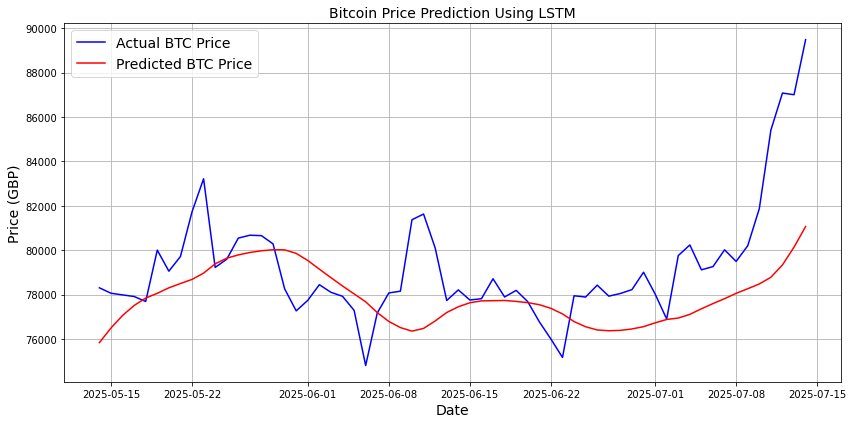

In [10]:
# Select Close price for forecasting
data = merged_data[['Close']].values


# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)


def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(x), np.array(y)

SEQ_LENGTH = 60  # Use past 60 days to predict next day
x, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split into train/test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

# Build LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Show model summary
model.summary()

# Train the model
history = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_split=0.1, verbose=1)

loss = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss:.4f}")


# Make predictions
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(y_test)

# Calculate evaluation metrics
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_prices, predicted_prices)
r2 = r2_score(actual_prices, predicted_prices)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

test_dates = merged_data.index[-len(y_test):] 

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(test_dates, actual_prices, color='blue', label='Actual BTC Price')
plt.plot(test_dates, predicted_prices, color='red', label='Predicted BTC Price')
plt.title('Bitcoin Price Prediction Using LSTM', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (GBP)', fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

# Hyperparamter Tuning

Fitting 2 folds for each of 2 candidates, totalling 4 fits
2/2 [==============================] - 1s 20ms/step
📊 Model Accuracy Metrics:
Mean Squared Error (MSE): 8516045.22
Root Mean Squared Error (RMSE): 2918.23
Mean Absolute Error (MAE): 2112.32
R² Score: -0.2391


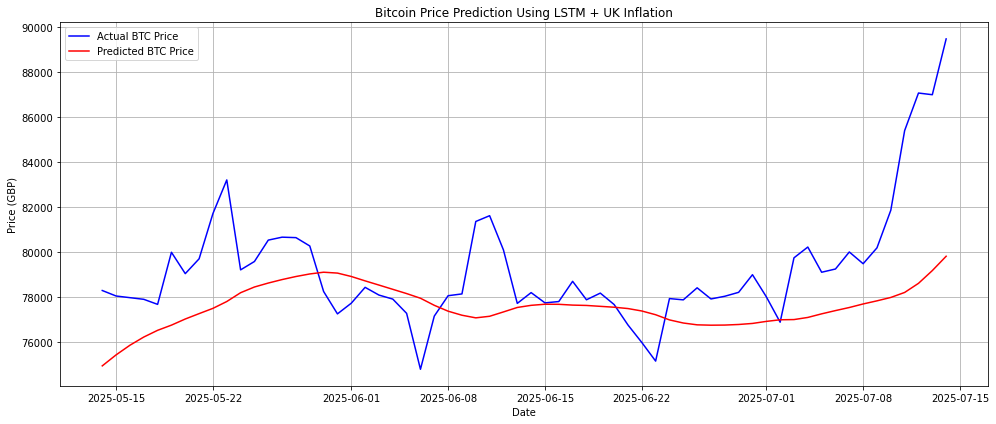

In [11]:
# Load and Prepare Dataset
merged_df = pd.read_csv("BTC_GBP_with_UK_Inflation.csv")
merged_df["Date"] = pd.to_datetime(merged_df["Date"])
merged_df.set_index("Date", inplace=True)

# select features (BTC Close and UK Inflation)
features = ['Close', 'Inflation_Rate']
data = merged_df[features].values

# Min-Max Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Creatinh Sequences for LSTM
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(seq_length, len(data)):
        x.append(data[i - seq_length:i])
        y.append(data[i, 0])  # predicting BTC Close
    return np.array(x), np.array(y)

SEQ_LENGTH = 60
x, y = create_sequences(scaled_data, SEQ_LENGTH)

# Train/Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

# Define LSTM Model Function for SciKeras
def build_lstm_model(units1=64, units2=32, dropout_rate=0.3, learning_rate=0.001, **kwargs):
    model = Sequential()
    model.add(LSTM(units1, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units2))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Wrap with SciKeras
regressor = KerasRegressor(model=build_lstm_model, verbose=0)

# Define Hyperparameter Grid (you can reduce for speed)
param_grid = {
    "model__units1": [64, 100],
    "model__units2": [32],
    "model__dropout_rate": [0.3],
    "model__learning_rate": [0.001],
    "batch_size": [32],
    "epochs": [20]
}

# Grid Search CV
grid_search = GridSearchCV(
    estimator=regressor,
    param_grid=param_grid,
    cv=2,
    scoring="neg_mean_squared_error",
    verbose=1,
    n_jobs=1  # safer with Keras on Windows
)

# Fitting model
grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_.model_

# Predict & Re-Scale
y_pred = best_model.predict(x_test).flatten()

# Inverse scale predictions
dummy_pred = np.zeros((len(y_pred), len(features)))
dummy_pred[:, 0] = y_pred
y_pred_actual = scaler.inverse_transform(dummy_pred)[:, 0]

dummy_actual = np.zeros((len(y_test), len(features)))
dummy_actual[:, 0] = y_test
y_test_actual = scaler.inverse_transform(dummy_actual)[:, 0]

# Evaluation Metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

print("Model Accuracy Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# Plot Predictions vs Actuals
test_dates = merged_df.index[-len(y_test):]

plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test_actual, label="Actual BTC Price", color="blue")
plt.plot(test_dates, y_pred_actual, label="Predicted BTC Price", color="red")
plt.title("Bitcoin Price Prediction Using LSTM + UK Inflation")
plt.xlabel("Date")
plt.ylabel("Price (GBP)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# GARCH Model

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.003
Vol Model:                      GARCH   Log-Likelihood:               -853.725
Distribution:                  Normal   AIC:                           1713.45
Method:            Maximum Likelihood   BIC:                           1725.15
                                        No. Observations:                  365
Date:                Tue, Jul 29 2025   Df Residuals:                      365
Time:                        13:29:53   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.9958      0.465      2.140  3.236e-02 [8.374e-0

<Figure size 864x432 with 0 Axes>

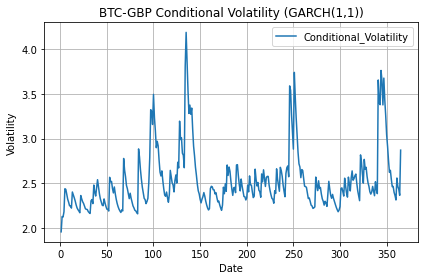

KeyError: "None of [Int64Index([304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316,\n            317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329,\n            330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342,\n            343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355,\n            356, 357, 358, 359, 360, 361, 362, 363, 364, 365],\n           dtype='int64')] are in the [columns]"

In [13]:
# Calculate daily returns
btc_data['Returns'] = btc_data['Close'].pct_change() * 100  # Converting to percentage
btc_data.dropna(inplace=True)

test_dates = btc_data.index[-len(y_test):]

#fit the GARCH model
garch_model = arch_model(
    btc_data['Returns'],
    mean='Zero',  # Zero-mean assumption
    vol='GARCH',
    p=1,          # AR order
    o=0,          # No exogenous variables
    q=1,
    dist='Normal'
)

# Fit the model
res = garch_model.fit(disp='off')

# Print summary
print(res.summary())

# Plot conditional volatility
vol_forecast = res._volatility
volatility_df = pd.DataFrame({
    'Date': btc_data.index,
    'Conditional_Volatility': vol_forecast
}).set_index('Date')

# Plot volatility
plt.figure(figsize=(12, 6))
volatility_df.plot(title='BTC-GBP Conditional Volatility (GARCH(1,1))')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True)
plt.tight_layout()
plt.show()

# Forecast future volatility
forecast = res.forecast(horizon=30)
forecast_vol = forecast.variance[-1:]  # Get last variance forecast
forecast_vol.plot(test_dates, title='30-Day Volatility Forecast')
plt.xlabel('Horizon')
plt.ylabel('Volatility')
plt.grid(True)
plt.tight_layout()
plt.show()

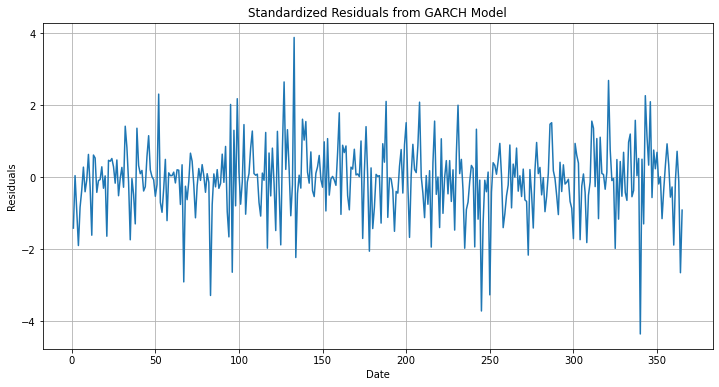

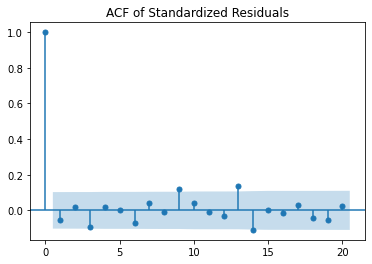

In [14]:
# Get standardized residuals
std_resid = res.resid / res.conditional_volatility

# Plot standardized residuals
plt.figure(figsize=(12, 6))
plt.plot(std_resid)
plt.title("Standardized Residuals from GARCH Model")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

# Check for autocorrelation in residuals
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(std_resid, lags=20)
plt.title("ACF of Standardized Residuals")
plt.show()

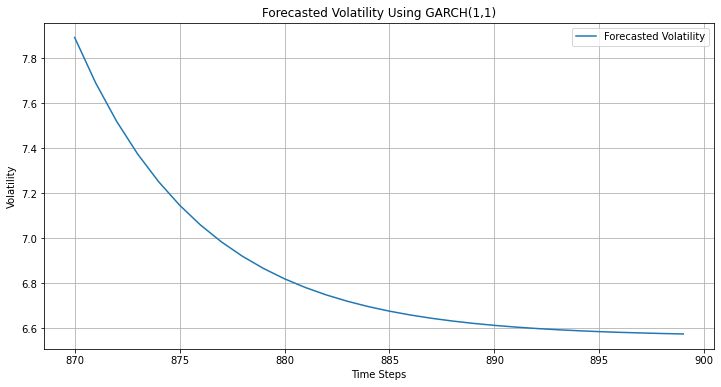

In [15]:
# Forecast future volatility
forecast_horizon = 30  # Number of days to forecast
forecast = res.forecast(horizon=forecast_horizon)

# Plot forecasted volatility
plt.figure(figsize=(12, 6))
plt.plot(forecast.variance.iloc[-forecast_horizon:].values.flatten(), label='Forecasted Volatility')
plt.title("Forecasted Volatility Using GARCH(1,1)")
plt.xlabel("Time Steps")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()